In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F #capas sin parametros

In [0]:
class Net(nn.Module):
  def __init__(self, num_channels):
    super(Net,self).__init__()
    
    self.num_channels = num_channels
    
    self.conv1 = nn.Conv2d(3, self.num_channels, 3, stride = 1, padding = 1)
    self.conv2 = nn.Conv2d(self.num_channels, self.num_channels*2, 3, stride = 1, padding = 1)
    self.conv3 = nn.Conv2d(self.num_channels*2, self.num_channels*4, 3, stride = 1, padding = 1)
    
    self.fc1 = nn.Linear(self.num_channels*4*8*8, self.num_channels*4)
    self.fc2 = nn.Linear(self.num_channels*4, 6)
    
  def forward(self,x):
      #Empieza 3x64x64
      x = self.conv1(x) # num_channels x 64 x 64
      x = F.relu(F.max_pool2d(x, 2)) # num_channels x 32 x 32
      x = self.conv2(x) # num_channels*2 x 32 x32
      x = F.relu(F.max_pool2d(x, 2)) #num_channels*2 x 16 x 16
      x = self.conv3(x) # num_channels*4 x16x16
      x = F.relu(F.max_pool2d(x, 2)) # num_channels*4 x 8 x 8

      #flatten
      x = x.view(-1, self.num_channels*4*8*8)

      #fc
      x = self.fc1(x)
      x = F.relu(x)
      x = self.fc2(x)

      #log_softmax

      x = F.log_softmax(x, dim=1)

      return x             

In [0]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
!ls '/gdrive/My Drive/dl-pytorch/datasets/64x64_SIGNS'

test_signs  train_signs  val_signs


In [0]:
import sys
sys.path.append('/gdrive/My Drive/dl-pytorch/')

In [0]:
from plot_helpers import imshow

In [0]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader

class SIGNSDataset(Dataset):
  def __init__(self, base_dir, split="train", transform=None):
    path = os.path.join(base_dir, "{}_signs".format(split))
    files = os.listdir(path)
    
    self.filenames = [os.path.join(path,f) for f in files if f.endswith(".jpg")]
    
    self.targets = [int(f[0]) for f in files]
    self.transform = transform
    
  def __len__(self):
    return len(self.filenames)
  
  def __getitem__(self,idx):
    image = Image.open(self.filenames[idx])
    if self.transform:
      image = self.transform(image)
    return image, self.targets[idx]

In [0]:
signs = SIGNSDataset('/gdrive/My Drive/dl-pytorch/datasets/64x64_SIGNS', split="train")

In [0]:
len(signs)

864

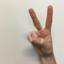

In [0]:
signs[0][0]

In [0]:
import torchvision.transforms as transforms

In [0]:
trainset = SIGNSDataset('/gdrive/My Drive/dl-pytorch/datasets/64x64_SIGNS', split="train", transform = transforms.ToTensor())

In [0]:
dataloader = DataLoader(trainset, batch_size=32)

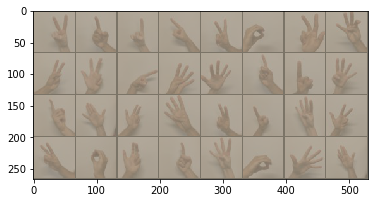

tensor([2, 1, 1, 1, 2, 0, 3, 4, 2, 3, 1, 4, 5, 1, 1, 4, 1, 5, 3, 4, 2, 1, 4, 3,
        2, 0, 3, 1, 4, 0, 5, 5])


In [0]:
from torchvision.utils import make_grid

for inputs, targets in dataloader:
  out = make_grid(inputs)
  imshow(out)
  print(targets)
  break

In [0]:
import torch.optim as optim

In [0]:
device = torch.device('cuda')

In [0]:
device

device(type='cuda')

In [0]:
net = Net(32).to(device)

loss_fn = nn.NLLLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum = 0.9)

In [0]:
class RunningMetric():
  def __init__(self):
    self.S = 0
    self.N = 0
    
  def update(self, val, size):
    self.S += val
    self.N += size
    
  def __call__(self):
    return self.S/float(self.N)

In [0]:
num_epochs = 100

In [0]:
for epoch in range(num_epochs):
  print('Epoch {}/{}'.format(epoch+1, num_epochs))
  print('-'*10)
  
  running_loss = RunningMetric() # perdida
  running_acc = RunningMetric() #precision
  
  for inputs, targets in dataloader:
    inputs, targets = inputs.to(device), targets.to(device)
    optimizer.zero_grad()
    
    outputs = net(inputs)
    _, preds = torch.max(outputs,1)
    loss = loss_fn(outputs, targets)
    
    loss.backward() #magias: gradientes calculados automaticamente
    optimizer.step() #magia2: actualiza las perillas o los parametros
    
    batch_size = inputs.size()[0]
    running_loss.update(loss.item()*batch_size,
                       batch_size)
    running_acc.update(torch.sum(preds == targets).float(),
                       batch_size)
  print("Loss: {:.4f} Acc: {:.4f} ".format(running_loss(),
                                          running_acc()))


In [0]:
x = torch.Tensor(2)
x.requires_grad=True
loss= 13*x[0] + 7*x[1] +1
loss.backward()
print(x)
x.grad

tensor([0., 0.], requires_grad=True)


tensor([13.,  7.])

In [0]:
x = torch.rand((2,3), requires_grad=True)
y = torch.Tensor([[1,2],[3,4]])
loss = y.mm(x)
loss = loss.sum()
loss.backward()
x.grad

tensor([[4., 4., 4.],
        [6., 6., 6.]])

In [0]:
train = True

with torch.set_grad_enabled(train):
  #computos con tesonres  

In [0]:
import optimizers_viz as optviz

In [0]:
problem = optviz.build_beales_problem()
constructors = optviz.build_optimizers(problem.lr)
params = optviz.build_params(problem)

WARN: your minima is not the true minima 2.5989631119152934 0.09724441229565892


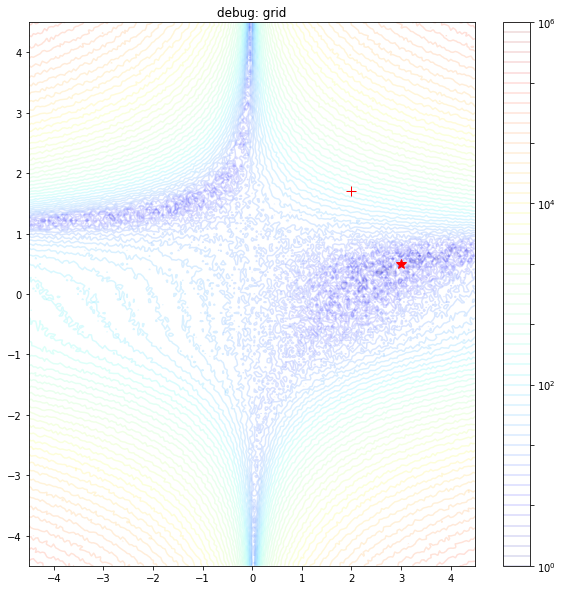

In [0]:
optviz.plot_minimized_function(params)

In [0]:
constructors

{'Adadelta': <function optimizers_viz.build_optimizers.<locals>.<lambda>>,
 'Adagrad': <function optimizers_viz.build_optimizers.<locals>.<lambda>>,
 'Adam': <function optimizers_viz.build_optimizers.<locals>.<lambda>>,
 'Adamax': <function optimizers_viz.build_optimizers.<locals>.<lambda>>,
 'RMSprop': <function optimizers_viz.build_optimizers.<locals>.<lambda>>,
 'SGD': <function optimizers_viz.build_optimizers.<locals>.<lambda>>,
 'momentum': <function optimizers_viz.build_optimizers.<locals>.<lambda>>,
 'momentum_dampen': <function optimizers_viz.build_optimizers.<locals>.<lambda>>,
 'nesterov': <function optimizers_viz.build_optimizers.<locals>.<lambda>>,
 'nesterov_decay': <function optimizers_viz.build_optimizers.<locals>.<lambda>>}

In [0]:
zpaths, results, distance, lrs = optviz.run_optimizers(problem, constructors, params)


SGD 178.76974609716808 	 True 	 False
momentum 166.71104986844935 	 True 	 False
momentum_dampen 164.99010313471447 	 True 	 False
nesterov 171.9433909204752 	 True 	 False
nesterov_decay 172.46106474817907 	 True 	 False
Adadelta 175.9179832902083 	 True 	 False
Adagrad 176.93446541341885 	 True 	 False
Adamax 173.66860481880704 	 True 	 False
RMSprop 168.28119740898458 	 True 	 False
Adam 173.3182067759674 	 True 	 False


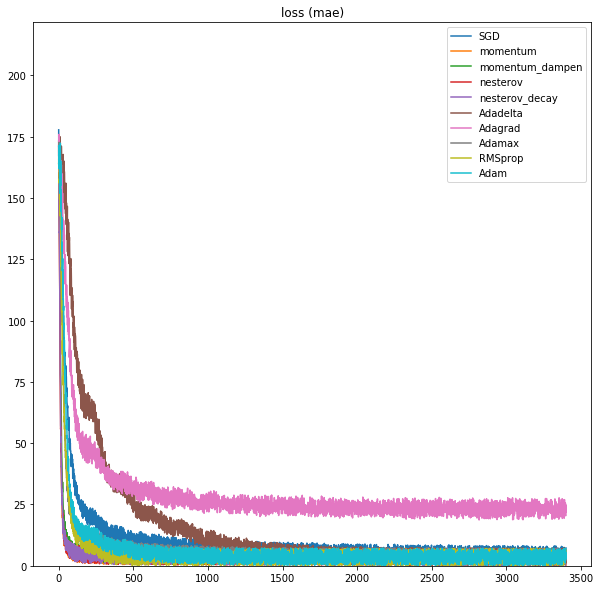

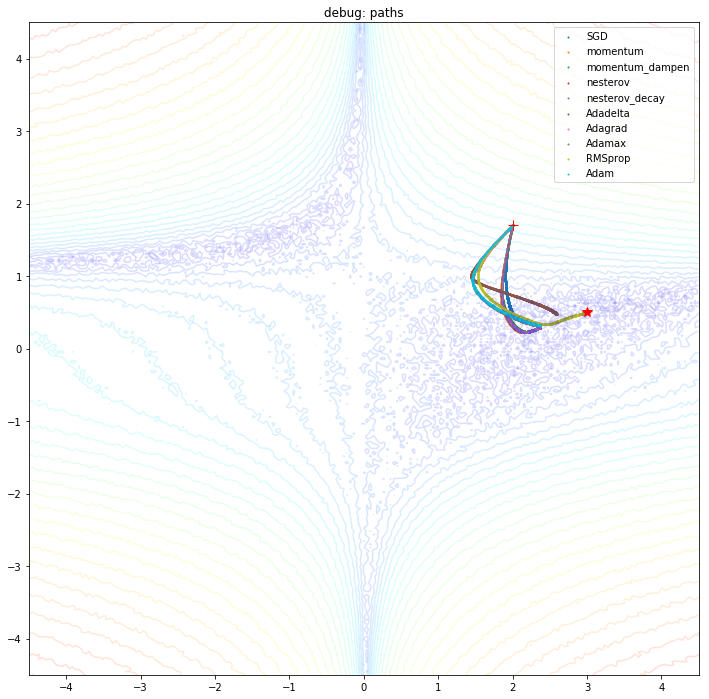

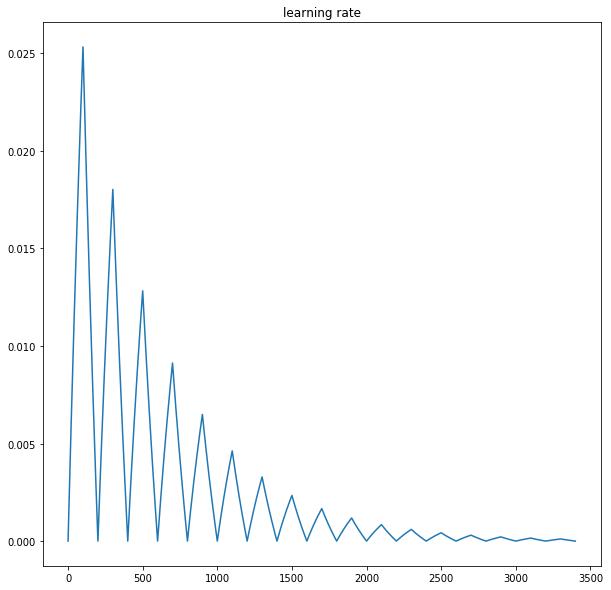

In [0]:
optviz.plot_optim_journeys(zpaths, results, distance, lrs, params)